# Slide model with nonlinear return mapping

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mayavi import mlab
import os.path

home_dir = os.path.expanduser('~')
#mlab.init_notebook()

 * Unresolved functions like back stress. It would be possible to define the state variable as time dependent functions from the very beginning - directly in the potential definition. Then. composed functions, like the thermodynamic forces would have the 
 * Implementation for multidimensional arguments - separation of elastic and inelastic material parameters within the domain - 
 * Algorithmic stiffness ... try to construct the derivative with respect to the total slip.
 * Skewness of the level set function in the kinematic space - check. 
 * Rule for the signs of the potential gradients - how to get it automatically
 * non-associated to associated?
 * two-dimensional interface
 * interaction with lateral damage
- Interaction between normal and tangential
- Evaluation of energy dissipation for individual mechanisms


## Material parameters

In [2]:
E_T = sp.Symbol('E_T', real=True, nonnegative=True)
E_N = sp.Symbol('E_N', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True)
K = sp.Symbol('K', real=True)
S_T = sp.Symbol('S_T', real=True)
S_N = sp.Symbol('S_N', real=True)
#r = sp.Symbol('r', real=True)
c_T = sp.Symbol('c_T', real=True)
c_N = sp.Symbol('c_N', real=True)
b = sp.Symbol('b', real=True) #new variable playing the role of coupling
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)
m = sp.Symbol('m', real=True)
sigma_T = sp.Symbol('sigma_T', real=True)

## State variables

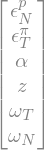

In [3]:
epsilon_N = sp.Symbol(r'\epsilon_N', real = True)
epsilon_N_p = sp.Symbol(r'\epsilon_N^{p}', real = True)
epsilon_T = sp.Symbol(r'\epsilon_T', real = True)
epsilon_T_pi = sp.Symbol(r'\epsilon_T^{\pi}', real = True)
omega_T = sp.Symbol('omega_T', real=True, nonnegative=True)
omega_T.is_nonnegative
omega_N = sp.Symbol('omega_N', real=True, nonnegative=True)
omega_N.is_nonnegative
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)
SV = sp.Matrix([epsilon_N_p, epsilon_T_pi, alpha, z, omega_T, omega_N])
SV

In [4]:
dot_lambda = sp.Symbol(r'\dot{\lambda}', real=True, nonnegative=True)

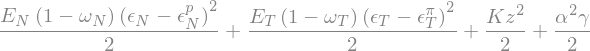

In [5]:
rho_phi = sp.Rational(1,2)* ((1-omega_N)*E_N*(epsilon_N - epsilon_N_p)**2 + (1-omega_T)*E_T*(epsilon_T-epsilon_T_pi)**2 \
                             + gamma * alpha**2 + K * z**2)
rho_phi

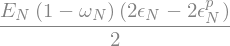

In [6]:
sigma_N = sp.Function(r'\sigma_N')(E_N,omega_N,epsilon_N,epsilon_N_p)
sigma_N = rho_phi.diff(epsilon_N)
#sp.solve(sigma_N, epsilon_N)
sigma_N

## Thermodynamic forces

In [7]:
#sigma_N = sp.Symbol(r'\sigma_N', real=True)
sigma_N_p = sp.Symbol(r'\sigma_N^{p}', real=True)
sigma_T_pi = sp.Symbol(r'\sigma_T^{\pi}', real=True)
sigma_pi = sp.Symbol(r'\sigma_pi', real=True)
X = sp.Symbol('X', real=True)
Z_T = sp.Symbol('Z_T', real=True, nonnegative=True)
Y_N = sp.Symbol('Y_N', real=True)
Y_T = sp.Symbol('Y_T', real=True)
TF = [sigma_N_p,sigma_T_pi, X, Z_T, Y_T, Y_N]
TF

## Threshold 

Define effective stresses as a function of the apparent stress and damage.  Note that $\tau_\pi = \tau$.

In [8]:
sigma_eff_T = sp.Function(r'\sigma^{\mathrm{eff}}')(sigma_T_pi, omega_T)
Q = sp.Function('Q')(sigma_eff_T,X)
sigma_eff_T

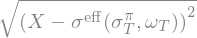

In [9]:
norm_Q = sp.sqrt(Q*Q)
sp.simplify(norm_Q.subs(Q,sigma_eff_T-X))

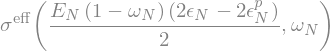

In [10]:
sigma_eff_N = sp.Function(r'\sigma^{\mathrm{eff}}')(sigma_N, omega_N)
Q = sp.Function('Q')(sigma_eff_T,X)
sigma_eff_N

In [11]:
f = norm_Q - (Z_T + tau_bar - m * sigma_eff_N) * (1 - sp.Heaviside(sigma_eff_N, 1) * (sigma_eff_N**2 / sigma_T))
f

  ⎛                          2⎛E_N⋅(1 - ω_N)⋅(2⋅\epsilon_N - 2⋅\epsilon_N__{p}
  ⎜    \sigma__{\mathrm{eff}} ⎜───────────────────────────────────────────────
  ⎜                           ⎝                       2                       
- ⎜1 - ───────────────────────────────────────────────────────────────────────
  ⎝                                                                           

)     ⎞  ⎛                      ⎛E_N⋅(1 - ω_N)⋅(2⋅\epsilon_N - 2⋅\epsilon_N__{
─, ω_N⎟⋅θ⎜\sigma__{\mathrm{eff}}⎜─────────────────────────────────────────────
      ⎠  ⎝                      ⎝                       2                     
──────────────────────────────────────────────────────────────────────────────
        σ_T                                                                   

p})     ⎞   ⎞⎞                                                                
───, ω_N⎟, 1⎟⎟                                                                
        ⎠   ⎠⎟ ⎛                                  

In [12]:
subs_Q = {Q: sigma_eff_T - X}
subs_Q

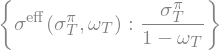

In [13]:
subs_sigma_eff_T = {sigma_eff_T: sigma_T_pi / (1-omega_T)}
subs_sigma_eff_T

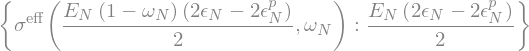

In [14]:
subs_sigma_eff_N = {sigma_eff_N: sigma_N / (1-omega_N)}
subs_sigma_eff_N

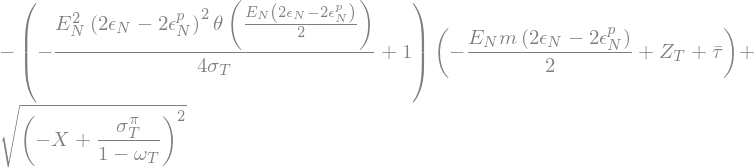

In [15]:
f_TF = f.subs(subs_Q).subs(subs_sigma_eff_T).subs(subs_sigma_eff_N)
f_TF

In [16]:
grad_f = sp.Matrix([ f.diff(tf) for tf in  TF ])
grad_f

⎡                                                                             
⎢                                                                             
⎢   _____________________________________________________                     
⎢  ╱  2                                                                       
⎢╲╱  Q (\sigma__{\mathrm{eff}}(\sigma_T__{\pi}, ω_T), X) ⋅────────────────────
⎢                                                         ∂\sigma__{\mathrm{ef
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                        _____________________
⎢                                                       ╱  2                  
⎢                                                     ╲╱  Q (\sigma__{\mathrm{
⎢                                                   

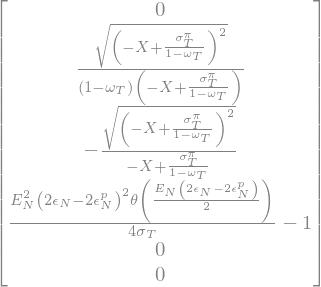

In [17]:
grad_f_TF = grad_f.subs(subs_Q).subs(subs_sigma_eff_T).subs(subs_sigma_eff_N).doit()
grad_f_TF

**Plot the threshold function**: for changing damage $\omega \in (0,1)$. 

In [18]:
def anim_levelset(get_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:80j, ymin:ymax:80j, zmin:zmax:80j]
    f_args = tuple(grid_args)+(0.00001,)
    f_val = get_f(*f_args)
    contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(1, 0, 0)
    )
    xl, yl, zl = labels
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            contour.mlab_source.scalars = get_f(*tuple(grid_args)+(omega_val,))
            yield

    anim()
    mlab.show()

In [19]:
if False:
    subs_f_TF_data = ({m:0, tau_bar:10})
    get_f = sp.lambdify(
        (tau_pi, X, Z, omega), 
        f_TF.subs(subs_f_TF_data), 'numpy')
    anim_levelset(get_f)

## Flow potential

In [20]:
Psi = sp.Function('\Psi')(Y_N, Y_T, omega_N, omega_T)

In [21]:
subs_Psi = {Psi: (1-omega_T)**c_T * ((Y_T**2 /(2 * S_T)) + b * ((Y_N * Y_T) / S_N)) + (1-omega_N)**c_N \
                                     * ((Y_N**2/(2*S_N))+b*(Y_T*Y_N / S_T)) * sp.Heaviside(sigma_eff_N, 1) }

In [22]:
psi = f + Psi
psi

  ⎛                          2⎛E_N⋅(1 - ω_N)⋅(2⋅\epsilon_N - 2⋅\epsilon_N__{p}
  ⎜    \sigma__{\mathrm{eff}} ⎜───────────────────────────────────────────────
  ⎜                           ⎝                       2                       
- ⎜1 - ───────────────────────────────────────────────────────────────────────
  ⎝                                                                           

)     ⎞  ⎛                      ⎛E_N⋅(1 - ω_N)⋅(2⋅\epsilon_N - 2⋅\epsilon_N__{
─, ω_N⎟⋅θ⎜\sigma__{\mathrm{eff}}⎜─────────────────────────────────────────────
      ⎠  ⎝                      ⎝                       2                     
──────────────────────────────────────────────────────────────────────────────
        σ_T                                                                   

p})     ⎞   ⎞⎞                                                                
───, ω_N⎟, 1⎟⎟                                                                
        ⎠   ⎠⎟ ⎛                                  

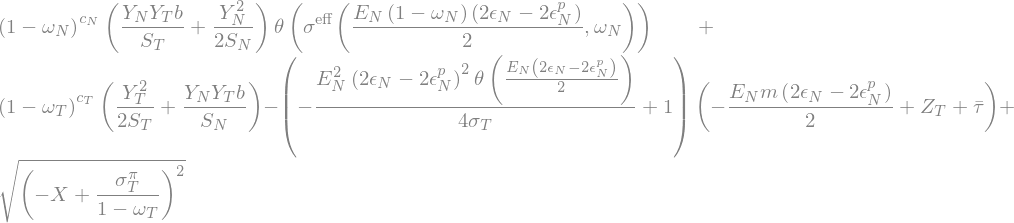

In [23]:
psi_TF = psi.subs(subs_Q).subs(subs_sigma_eff_T).subs(subs_sigma_eff_N).subs(subs_Psi)
psi_TF

In [24]:
if False:
    subs_psi_data = {tau_bar:10, m:0, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        [tau_pi, X, Y, omega],
        psi_TF.subs(subs_psi_data), 'numpy')
    anim_levelset(get_psi, zrange=(-10,10))

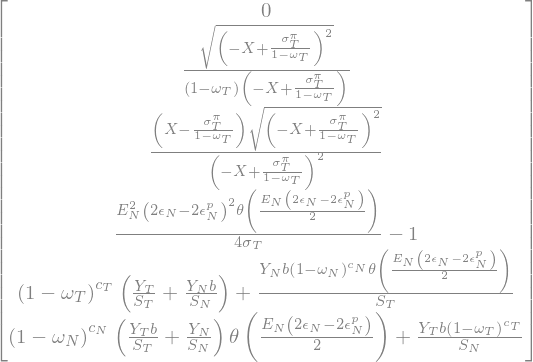

In [25]:
signs = sp.diag(1,1,1,1,1,1)
grad_psi = signs * sp.Matrix([psi_TF.diff(tf) for tf in TF])
#grad_psi_TF = grad_psi.subs(subs_sigma_eff_T).subs(subs_Q)
grad_psi_TF = grad_psi.subs(subs_Psi).subs(subs_Q).subs(subs_sigma_eff_T).subs(subs_sigma_eff_N).doit()
grad_psi_TF

In [26]:
subs_d_psi_TF = {var: val for var, val in zip(TF, grad_psi_TF)}

In [27]:
def anim_quiver3d(get_f, get_grad_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:20j, ymin:ymax:20j, zmin:zmax:20j]
    f_args = tuple(grid_args)+(tmin,)
    f_val = get_f(*f_args)
    f_contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(0, 1, 0)
    )
    x, y, z = grid_args
    psi_val = get_grad_f(*f_args)
    u, v, w = psi_val[(0,1,3),0]
    quiver = mlab.quiver3d(x,y,z,u,v,w)

    xl, yl, zl = labels 
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            f_args = tuple(grid_args)+(omega_val,)
            f_contour.mlab_source.scalars = get_f(*f_args)
            psi_val = get_grad_f(*f_args)
            u, v, w = psi_val[(0,1,3),0]
            quiver.mlab_source.u = u
            quiver.mlab_source.v = v
            quiver.mlab_source.w = w
            yield

    anim()
    mlab.show()

In [28]:
if False:
    subs_psi_data = {tau_bar:10, m:0, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        (tau_pi, X, Y, omega), 
        psi_TF.subs(subs_psi_data), 'numpy')
    get_grad_psi = sp.lambdify(
        [tau_pi, X, Y, omega], 
        grad_psi_TF.subs(subs_psi_data), 'numpy')
    anim_quiver3d(get_psi, get_grad_psi, 
                  xrange=(-30,30), yrange=(-30,30), zrange=(-5,5), trange=(0.001, 0.1))

## Thermodynamic forces

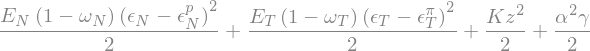

In [29]:
rho_phi

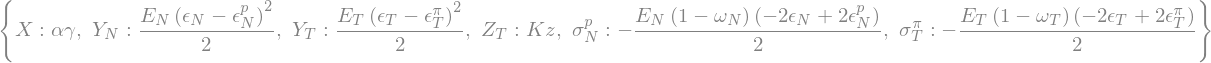

In [30]:
signs = sp.diag(-1,-1,1,1,-1,-1)
grad_rho_phi = sp.Matrix([rho_phi.diff(sv) for sv in SV])
subs_TF = {
  var: val for var,val in zip(TF,signs*grad_rho_phi)
}
subs_TF

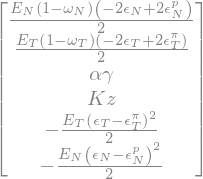

In [31]:
TF_SV = grad_rho_phi
TF_SV

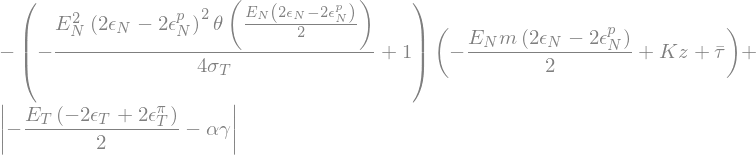

In [32]:
f_SV = f_TF.subs(subs_TF)
f_SV

Flow potential expressed in terms of the kinematic state variables

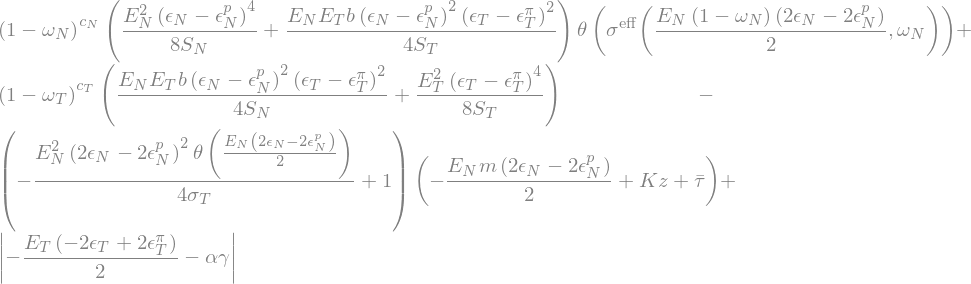

In [33]:
psi_SV = psi_TF.subs(subs_TF)
psi_SV

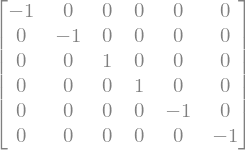

In [34]:
signs

In [35]:
if False:
    subs_psi_SV_data = {K:0.0001, S:0.0001, r:0.1, c:3, m:0, E_b:1, s:0, gamma:1, tau_bar:1}
    get_psi_SV = sp.lambdify(
        (s_pi, alpha, z, omega), 
        psi_SV.subs(subs_psi_SV_data), 'numpy')
    grad_psi_SV = signs * grad_psi_TF.subs(subs_TF)
    get_grad_psi_SV = sp.lambdify(
        (s_pi, alpha, z, omega), 
        grad_psi_SV.subs(subs_psi_SV_data), 'numpy')
    anim_quiver3d(get_psi_SV, get_grad_psi_SV, 
                  xrange=(-3,3), yrange=(-3,3), zrange=(-3,3),
                  trange=(0,0.1))

## Evolution equations

**Rates of state variables:**

In [36]:
dot_epsilon_T, t = sp.symbols(r'\dot{\epsilon_T}, t')
dot_epsilon_T, t

In [37]:
epsilon_T_t = sp.Function(r'epsilon_T')(t)
epsilon_N_t = sp.Function(r'epsilon_N')(t)
epsilon_N_p_t= sp.Function(r'epsilon_N_p')(t)
epsilon_T_pi_t = sp.Function(r'epsilon_T_pi')(t)
alpha_t = sp.Function(r'alpha')(t)
z_t = sp.Function(r'z')(t)
omega_T_t = sp.Function(r'omega_T')(t)
omega_N_t = sp.Function(r'omega_N')(t)
epsilon_T_pi_t

In [38]:
def var_timify( var ):
    return sp.Function(var.name+'_t')(t)
def var_dotify( var ):
    return sp.Symbol(r'\dot{%s}' % var) 

In [39]:
subs_SV_t = {
    var_timify(var) : var for var in SV
}
subs_SV_t;

In [40]:
dot_SV_t = dot_lambda * grad_psi_TF.subs(subs_TF)
subs_dot_SV_t = {
    var_timify(var).diff(t): sp.simplify(val) 
    for var, val in zip(SV, dot_SV_t)
}
subs_dot_SV_t;

## Rates of thermodynamic forces

In [41]:
subs_timify = {var: var_timify(var)
              for var in list(SV) + [epsilon_T]}
subs_untimify = {var_timify(var): var
              for var in list(SV)}
subs_timify, subs_untimify;

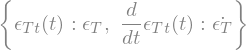

In [42]:
dot_epsilon_T = sp.Symbol(r'\dot{\epsilon_T}')
subs_s_untimify = {var_timify(epsilon_T):epsilon_T, var_timify(epsilon_T).diff(t): dot_epsilon_T} 
subs_s_untimify

In [43]:
dot_TF = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t)
    for tf in TF ])
dot_TF;

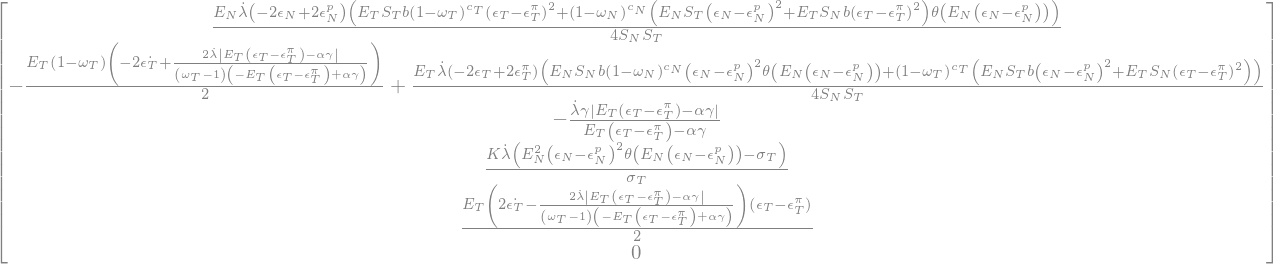

In [44]:
dot_TF_SV = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t).subs(subs_dot_SV_t).subs(subs_untimify).subs(subs_s_untimify)
    for tf in TF ])
dot_TF_SV

## Consistency condition

In [45]:
dot_f = sp.simplify((grad_f_TF.subs(subs_TF).T * dot_TF_SV)[0,0])

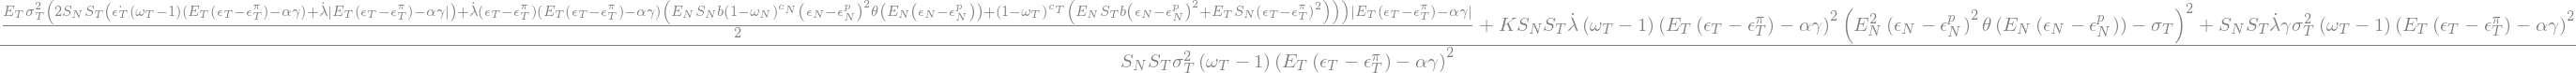

In [46]:
dot_f

## Return mapping expression

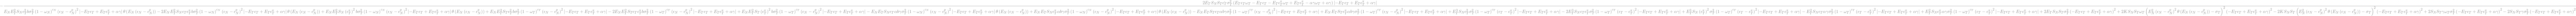

In [47]:
dot_lambda_solved = sp.solve(dot_f, dot_lambda)[0]
dot_lambda_simplified = sp.simplify(dot_lambda_solved)
dot_lambda_simplified

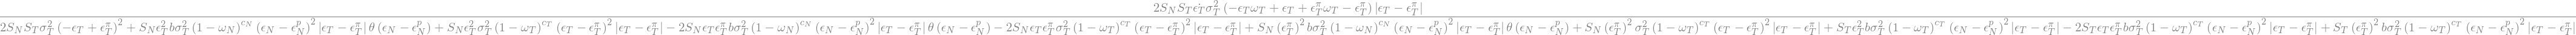

In [48]:
data_dict = {E_T:1, E_N:1, K:0, gamma:0} #              gamma:1, K:1, S:1, r:1, c:1, m:1, tau_bar:1, sigma_N : 0}
dot_lambda_solved.subs(data_dict)

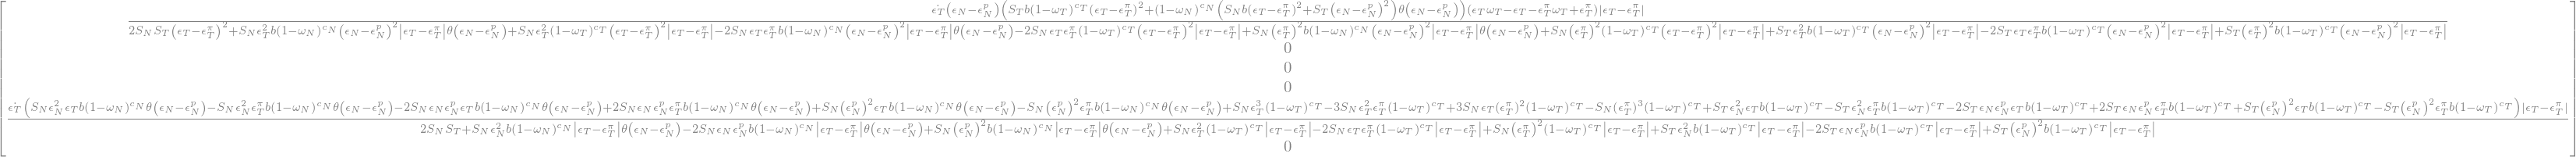

In [49]:
sp.simplify(dot_TF_SV.subs(dot_lambda, dot_lambda_solved).subs(data_dict))

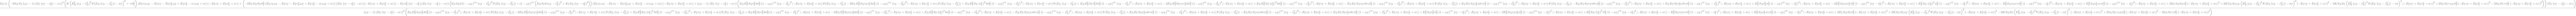

In [50]:
sp.simplify(dot_f.subs(dot_lambda, dot_lambda_solved))

## Test of consistency recovery

In [51]:
data_dict = {E_T:1, E_N: 1, gamma:1, K:1, S_T:1, S_N:1, c_T:1, c_N:1, m:1, tau_bar:1}#, sigma_N : 0

In [52]:
state_dict = {epsilon_T:5, alpha:0, z:0, epsilon_T_pi:1, omega_T:sp.Rational(1,2), omega_N:sp.Rational(1,2) }

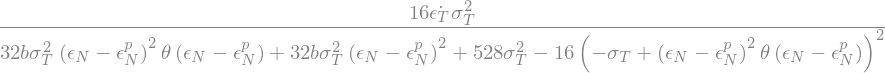

In [53]:
dot_lambda_test = dot_lambda_solved.subs(data_dict).subs(state_dict)
dot_lambda_test

In [54]:
sp.simplify(dot_f.subs(data_dict).subs(state_dict).subs(dot_lambda, dot_lambda_test))

In [55]:
from sympy.utilities.codegen import codegen

In [56]:
#codegen(('dot_lambda', dot_lambda_state),'C89')

In [57]:
#sp.lambdify(omega, dot_lambda_state,'numpy');

# Time integration scheme

In [58]:
material_params = {
    E_T:1, 
    E_N:1,
#    gamma:0, K:0, 
    gamma:0, K:0, 
#    S:0, r:0.001, c:1, 
    S_T:0.006, c_T:1,
    S_N:0.006, c_N:1,
    tau_bar:1, 
    m:0.1,
    sigma_N:1
}

## Discrete evolution equations

In [59]:
epsilon_N_p_n,epsilon_T_pi_n, z_n, alpha_n = sp.symbols(
    r'epsilon_N_p_n, epsilon_T_pi_n, z_n, alpha_n', real=True)
omega_T_n, omega_T_k = sp.symbols(
    r'omega_T_n, omega_T_k', real=True, nonnegative=True)
omega_N_n, omega_N_k = sp.symbols(
    r'omega_N_n, omega_N_k', real=True, nonnegative=True)
epsilon_N_p_k, epsilon_T_pi_k, z_k, alpha_k = sp.symbols(
    r'epsilon_N_p_k, epsilon_T_pi_k, z_k, alpha_k', real=True)
dlambda_ = sp.Symbol('lambda_Delta', nonnegative=True)
subs_state_n = {epsilon_N_p_n: epsilon_N_p_n, epsilon_T_pi: epsilon_T_pi_n, alpha: alpha_n, omega_T: omega_T_n, omega_N: omega_N_n, z: z_n }
subs_state_k = {epsilon_N_p_k: epsilon_N_p_k, epsilon_T_pi: epsilon_T_pi_k, alpha: alpha_k, omega_T: omega_T_k, omega_N: omega_N_k, z: z_k }

**Discrete evolution equatins**

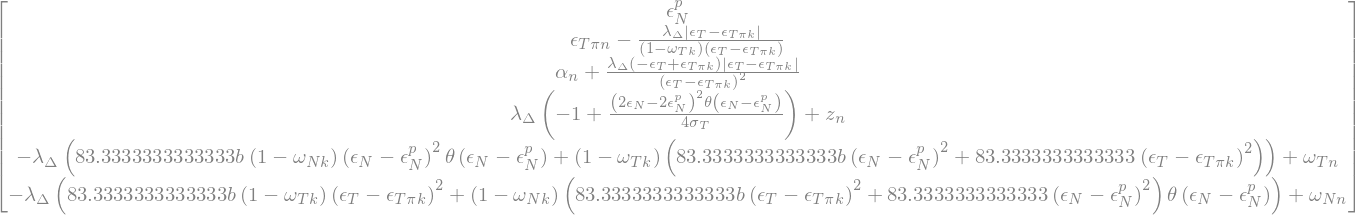

In [60]:
SV_n = sp.Matrix([sv.subs(subs_state_n) for sv in SV])
SV_k = sp.Matrix([sv.subs(subs_state_k) for sv in SV])
SV_k_expr =  SV_n + dlambda_ * signs * grad_psi_TF.subs(subs_TF).subs(subs_state_k)
subs_SV_k_expr = {
     sv: expr for sv, expr in zip(SV, list(SV_k_expr))
 }
get_SV_k = sp.lambdify(
        (epsilon_N,epsilon_T, dlambda_, SV_n, SV_k), SV_k_expr.subs(material_params), 'numpy')
SV_k_expr.subs(material_params)

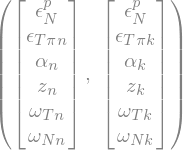

In [61]:
SV_n, SV_k

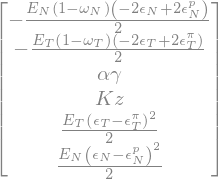

In [62]:
S_TF_SV = signs * TF_SV
S_TF_SV

## Updating State Variables

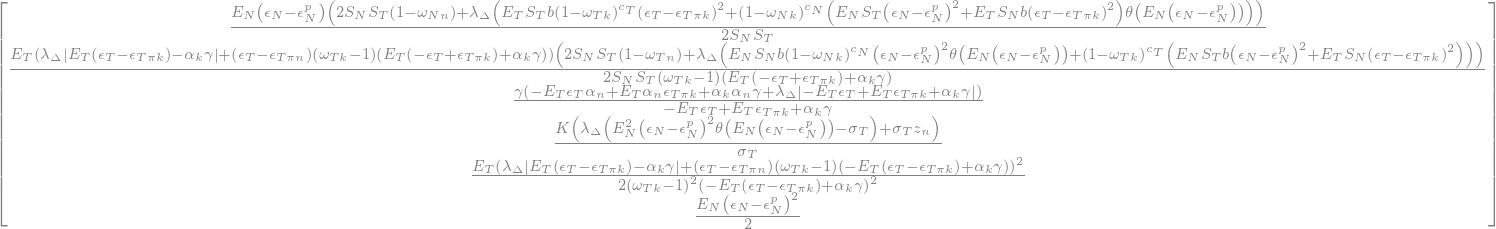

In [63]:
S_TF_SV_usv = S_TF_SV.subs(subs_SV_k_expr)
S_TF_SV_usv1 =sp.simplify(S_TF_SV_usv)
S_TF_SV_usv1

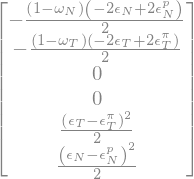

In [64]:
get_TF_k = sp.lambdify(
     (epsilon_N,epsilon_T, SV), S_TF_SV.subs(material_params), 'numpy'
)
S_TF_SV.subs(material_params)

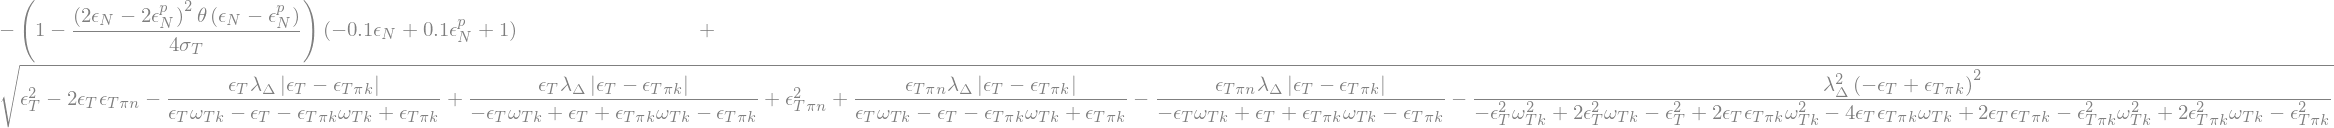

In [65]:
f_SV_k = f_SV.subs(subs_SV_k_expr)
get_f_SV_k = sp.lambdify(
       (epsilon_N,epsilon_T, dlambda_, SV_n, SV_k), f_SV_k.subs(material_params), 'numpy'
)
f_SV_k.subs(material_params)

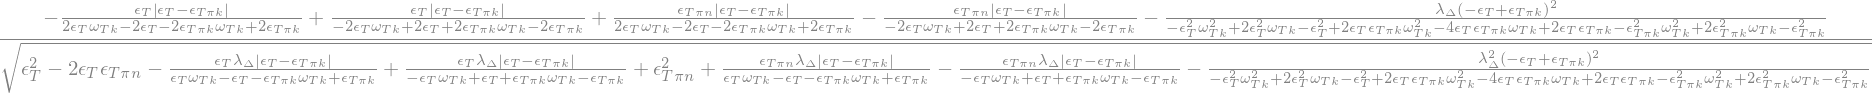

In [66]:
d_f_SV_k = f_SV_k.diff(dlambda_)
get_d_f_SV_k = sp.lambdify(
    (epsilon_T, dlambda_, SV_n, SV_k), d_f_SV_k.subs(material_params), 'numpy'
)
d_f_SV_k.subs(material_params)

In [67]:
def get_response(s_max=12.6,n_steps=20):
    sv_n = np.zeros((len(SV),), dtype=np.float_)
    sv_k = np.zeros((len(SV),), dtype=np.float_)
    sv_record, tf_record, k_record = [], [], []
    k_max = 2000
    s_t = np.linspace(1e-9,s_max,n_steps+1)
    #print(s_t)
    for s_n in s_t: 
        dlambda0 = 0
        f0 = get_f_SV_k(s_n,s_n,dlambda0,sv_n,sv_k)
        norm_f0 = f0
        k = 0
        while k < k_max:
            if norm_f0 < 1e-10:
                sv_n = np.copy(sv_k)
                tf_n = get_TF_k(s_n,s_n,sv_n).flatten()
                sv_record.append(sv_n)
                tf_record.append(tf_n)
                k_record.append(k)
                break
            df0 = get_d_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            dlambda0 -= f0/df0
            sv_k = get_SV_k(s_n,s_n,dlambda0,sv_n,sv_k).flatten()
            f0 = get_f_SV_k(s_n,s_n,dlambda0,sv_n,sv_k)
            norm_f0 = np.fabs(f0)
            k += 1
        else:
            print('no convergence')
    return (
        s_t, np.array(sv_record,dtype=np.float_),
        np.array(tf_record,dtype=np.float_),
        np.array(k_record,dtype=np.float_)
    )

NameError: name 'Heaviside' is not defined

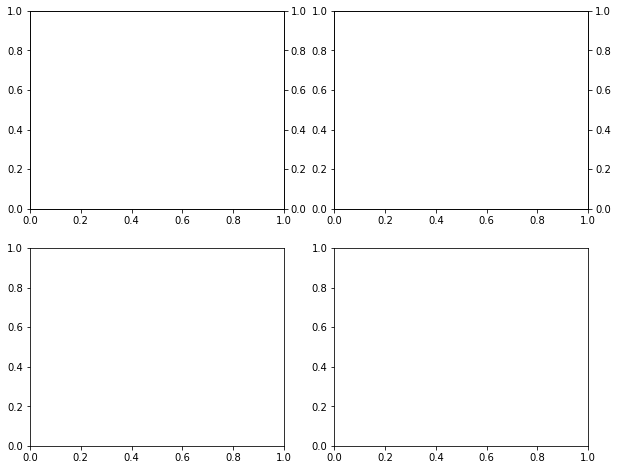

In [68]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))
ax11 = ax1.twinx()
ax22 = ax2.twinx()
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step_range = np.arange(1,2)*10
s_max = 1
for n_step, color in zip(n_step_range, colors):
    s_t, sv_arr, tf_arr, k_arr = get_response(s_max,n_step)
    #print((tf_arr[:,0]))
    ax1.plot(s_t, tf_arr[:,0], color=color, 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax11.plot(s_t, k_arr[:], '-.', color=color )
    ax2.plot(s_t, sv_arr[:,3], color=color, 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax22.plot(s_t, tf_arr[:,3], '-.', color=color, 
             label='n_steps = %g' % n_step)
    ax22.set_ylabel('$Y$')
    ax3.plot(s_t, tf_arr[:,1], color=color, 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$X$')
    ax4.plot(s_t, tf_arr[:,2], color=color, 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')

## Consistent Tangent Operator

### Algorithmic Stiffness from the book

In [ ]:
#NEW Method 
diff_s = S_TF_SV_usv1[0].diff(epsilon_T)
diff_s_1 = sp.simplify(diff_s)
diff_s_1.subs(material_params)

In [ ]:
get_alg_stiffness = sp.lambdify((epsilon_T,dlambda_,SV_n, SV_k), diff_s_1.subs(material_params), 'numpy')
get_alg_stiffness;

### Secant Stiffnes

In [ ]:
E_sec= sp.Symbol('E', real=True)
E_sec = (1-omega_T)*E_T
get_E_sec = sp.lambdify(
    (epsilon_T, SV),E_sec.subs(material_params), 'numpy'
)
E_sec

### Algorithmic Stiffness from the Paper

In [ ]:
# E= sp.Symbol('E', real=True)
# E = (1 - omega) * E_b - ((1 - omega) * E_b**2) /(E_b +(gamma+K) * (1-omega))-((1 - omega)**c *E_b**2 * (s - s_pi) \
#                             * (Y/S)** r * sp.sign(tau_pi/(1 - omega) - X))/(E_b/(1 - omega) + gamma + K)
# get_E_stiff = sp.lambdify(
#     (s, SV),E.subs(subs_TF).subs(material_params), 'numpy'
# )
# E 

In [ ]:
def get_response(s_max=12.6,n_steps=100):
    sv_n = np.zeros((len(SV),), dtype=np.float_)
    sv_k = np.zeros((len(SV),), dtype=np.float_)
    sv_record, tf_record, k_record, alg_stiff_record, e_stiff_ppr, e_stiff_sec= [], [], [], [], [], []
    k_max = 2000
    s_t = np.linspace(1e-9,s_max,n_steps+1)
    for s_n in s_t:
        dlambda0 = 0
        f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
        norm_f0 = f0 
        k = 0
        while k < k_max:
            if norm_f0 < 1e-10:
                sv_n = np.copy(sv_k)
                tf_n = get_TF_k(s_n,sv_n).flatten() 
                algstiff = get_alg_stiffness(s_n,dlambda0,sv_n, sv_k).flatten()
                alg_stiff_record.append(algstiff)  
                E_stiff = get_E_stiff(s_n,sv_n).flatten()
                e_stiff_ppr.append(E_stiff)
                E_sec = get_E_sec(s_n,sv_n).flatten()
                e_stiff_sec.append(E_sec)
                sv_record.append(sv_n)
                tf_record.append(tf_n)
                k_record.append(k)
                break
            df0 = get_d_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            dlambda0 -= f0/df0
            sv_k = get_SV_k(s_n,dlambda0,sv_n,sv_k).flatten()
            f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            norm_f0 = np.fabs(f0)
            k += 1
        else:
            print('no convergence')
    return (
        s_t, np.array(sv_record,dtype=np.float_),
        np.array(tf_record,dtype=np.float_),
        np.array(k_record,dtype=np.float_),
        np.array(alg_stiff_record,dtype=np.float_),
        np.array(e_stiff_ppr,dtype=np.float_),
        np.array(e_stiff_sec,dtype=np.float_)
    )

In [ ]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(10,8))
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step_range = np.arange(1,5)*10
s_max = 10
for n_step, color in zip(n_step_range, colors):
    s_t, sv_arr, tf_arr, k_arr, alg_arr, e_ppr, e_sec = get_response(s_max,n_step)
    ax1.plot(s_t, alg_arr[:], color=color, 
              label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$E_{alg}$')
    ax1.legend()
    ax2.plot(s_t, tf_arr[:,0], color=color, 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\tau$')
    ax2.legend()
    ax3.plot(s_t, e_ppr[:], color=color, 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel('$E$')
    ax3.legend()
    ax4.plot(s_t, e_sec[:], color=color, 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel('$Es$')
    ax4.legend()
f_name = os.path.join(home_dir,'m0.1gamma0.1K1.5.pdf')
fig.savefig(f_name);